In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as d
import matplotlib.pyplot as plt
import json
import sklearn

In [6]:
#Load Samples

with open('Data/Samples/data_20k.json') as json_file:
    data = json.load(json_file)
    p = np.zeros((3*time_length, data['Description'][0]['samplenum']))
    y_target = np.zeros((data['Description'][0]['samplenum'], 3))
    for i, p_i in enumerate(data['parameter']):
        p[:, i] = np.array(p_i)
    for s, y_s in enumerate(data['y_target']):
        y_target[s, :] = np.array(y_s)
        #y_target[s, 1] = y_target[s, 1]-1 #min-max scaling 
p = p.transpose()

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

y_target = torch.tensor(y_train).float()
p = torch.tensor(p_train).float()
y_test = torch.tensor(y_test).float()
p_test = torch.tensor(p_test).float()

In [9]:
#Parameters
time_length = 60; #seconds
sampletot = 20000
samplenum = 15000
testsize = 1-samplenum/sampletot
input_size = 3
output_size = 3*time_length
learning_rate = 0.01

epochs_s = [250]
batchsize_s = [50, 100]
LRdecay_s = [0.8, 0.7]
hiddenlayers_s = [[150], [100], [200]] 

epoch: 249 loss: 0.00000005

Duration: 16.192 min


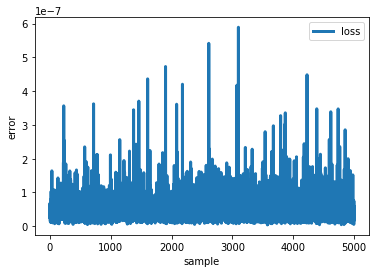

TOTAL ERROR: 0.000248331266137658    epochs: 250    batchsize: 50   LRdecay: 0.8
[150]
epoch: 249 loss: 0.00000008

Duration: 32.428 min


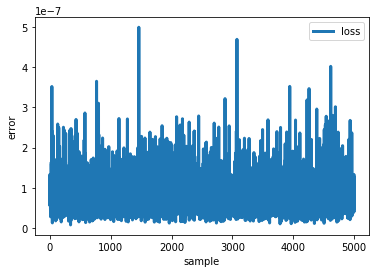

TOTAL ERROR: 0.00039980748624124374    epochs: 250    batchsize: 50   LRdecay: 0.8
[100]
epoch: 249 loss: 0.00000006

Duration: 56.711 min


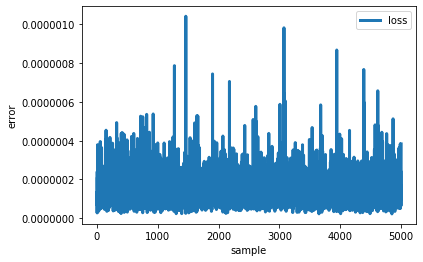

TOTAL ERROR: 0.0007368990667053765    epochs: 250    batchsize: 50   LRdecay: 0.8
[200]
epoch: 249 loss: 0.00000004

Duration: 75.457 min


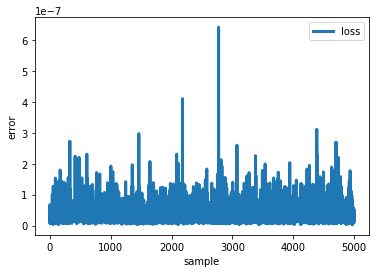

TOTAL ERROR: 0.00018502656204999468    epochs: 250    batchsize: 50   LRdecay: 0.7
[150]
epoch: 249 loss: 0.00000002

Duration: 94.482 min


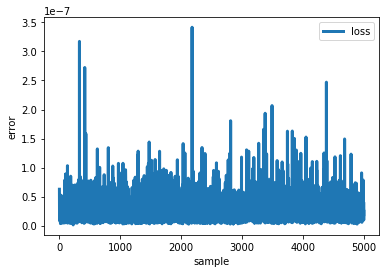

TOTAL ERROR: 0.00013314988994406196    epochs: 250    batchsize: 50   LRdecay: 0.7
[100]
epoch: 249 loss: 0.00000004

Duration: 113.129 min


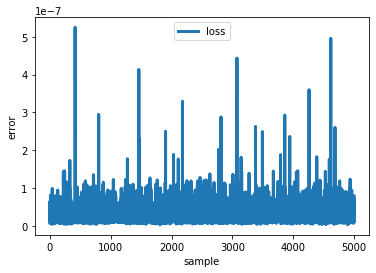

TOTAL ERROR: 0.00015813703980827043    epochs: 250    batchsize: 50   LRdecay: 0.7
[200]
epoch: 249 loss: 0.00000020

Duration: 121.249 min


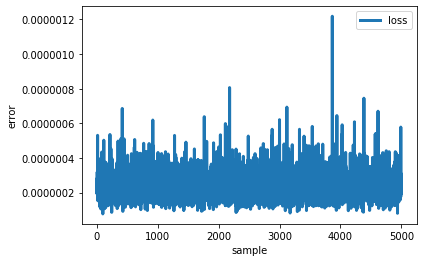

TOTAL ERROR: 0.0011853858701442732    epochs: 250    batchsize: 100   LRdecay: 0.8
[150]
epoch: 249 loss: 0.00000013

Duration: 128.847 min


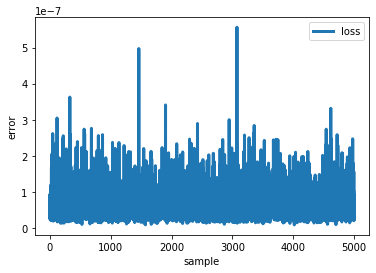

TOTAL ERROR: 0.0003253569978456383    epochs: 250    batchsize: 100   LRdecay: 0.8
[100]
epoch: 249 loss: 0.00000004

Duration: 136.852 min


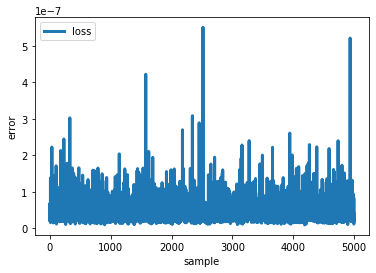

TOTAL ERROR: 0.00024040916495771114    epochs: 250    batchsize: 100   LRdecay: 0.8
[200]
epoch: 249 loss: 0.00000004

Duration: 144.679 min


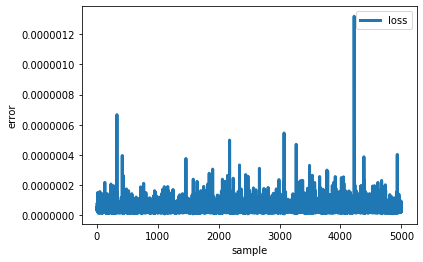

TOTAL ERROR: 0.0002445133238917485    epochs: 250    batchsize: 100   LRdecay: 0.7
[150]
epoch: 249 loss: 0.00000006

Duration: 152.202 min


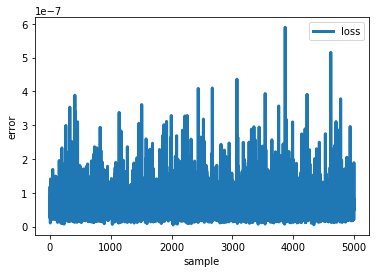

TOTAL ERROR: 0.0003253800674989371    epochs: 250    batchsize: 100   LRdecay: 0.7
[100]
epoch: 249 loss: 0.00000006

Duration: 160.178 min


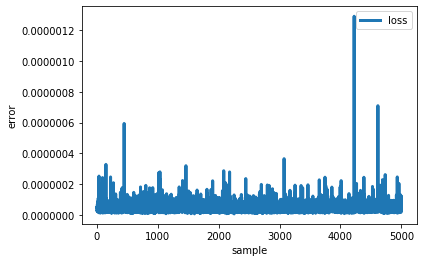

TOTAL ERROR: 0.00023294943779506028    epochs: 250    batchsize: 100   LRdecay: 0.7
[200]

Duration: 160.205 min


In [10]:
start_time = time.time()
tot_losses = []
for e1 in epochs_s:
    for b1 in batchsize_s:
        for d in LRdecay_s:
            for h in hiddenlayers_s:
                class ActiveLearn(nn.Module):

                    def __init__(self, n_in, out_sz):
                        super(ActiveLearn, self).__init__()

                        self.L_in = nn.Linear(n_in, h[0])
                        self.H1 = nn.Linear(h[0], 3*time_length)
                        #self.H2 = nn.Linear(h[1], 3*time_length)
                        #self.H3 = nn.Linear(h[2], 3*time_length)
                        self.L_out = nn.Linear(3*time_length, 3*time_length)
                        self.Relu = nn.ReLU(inplace=True)
                        #self.drop = nn.Dropout(p=0.3)
                        #self.norm1 = nn.BatchNorm2d(h[0])
                        #self.norm2 = nn.BatchNorm2d(h[1])
                    
                    def forward(self, input):
                        x = self.L_in(input)
                        #x = self.norm1(x)
                        #x = self.drop(x)
                        x = self.Relu(x)
                        x = self.H1(x)
                        #x = self.norm2(x)
                        x = self.Relu(x)
                        #x = self.H2(x)
                        #x = self.Relu(x)
                        #x = self.H3(x)
                        #x = self.Relu(x)
                        x = self.L_out(x)
                        return x


                model = ActiveLearn(input_size, output_size)

                criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=d, last_epoch=-1)
                #train
                torch.autograd.set_detect_anomaly(True)
                weight_c1 = 1 # p error condition
                batch = np.floor(samplenum/b1).astype(int)
                losses= []
                p_smoothness_errors = []
                basic_errors = [] #y_end_ and p_start error
                for e in range(e1):
                    for b in range(batch):
                        loss_batch = 0
                        smoothness_error_batch = 0
                        y_i = y_target[b*b1:b*b1+b1,:]
                        p_i = p[b*b1:b*b1+b1,:]
                        p_pred = model(y_i)

                        #error claculation
                        loss = weight_c1* criterion(p_pred, p_i)
                        losses.append(loss)
                        optimizer.zero_grad()
                        #Back Prop
                        loss.backward()
                        optimizer.step()
                    scheduler.step()
                    LR= scheduler.get_lr()
                    
                print(f'epoch: {e:3} loss: {loss.item():10.8f}') # print the last line
                print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed


                #Test the data
                #model.eval()
                losses_test= []
                with torch.no_grad():
                    for i in range(sampletot-samplenum):
                        p_val = model(y_test[i, :])
                        loss2 = criterion(p_val,p_test[i,:])
                        losses_test.append(loss2.clone().numpy())
                #plot test errors
                loss2 = plt.plot(losses_test, label = 'loss', linewidth=3)
                plt.legend()
                plt.ylabel('error')
                plt.xlabel('sample')
                plt.show()
                tot_error = sum(losses_test)
                tot_losses.append([tot_error, e1, b1, d, h])
                print(f'TOTAL ERROR: {tot_error}    epochs: {e1}    batchsize: {b1}   LRdecay: {d}')
                print(h)
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

In [11]:
for i in range(len(tot_losses)):
    print(tot_losses[i])
layer1 = tot_losses

[0.000248331266137658, 250, 50, 0.8, [150]]
[0.00039980748624124374, 250, 50, 0.8, [100]]
[0.0007368990667053765, 250, 50, 0.8, [200]]
[0.00018502656204999468, 250, 50, 0.7, [150]]
[0.00013314988994406196, 250, 50, 0.7, [100]]
[0.00015813703980827043, 250, 50, 0.7, [200]]
[0.0011853858701442732, 250, 100, 0.8, [150]]
[0.0003253569978456383, 250, 100, 0.8, [100]]
[0.00024040916495771114, 250, 100, 0.8, [200]]
[0.0002445133238917485, 250, 100, 0.7, [150]]
[0.0003253800674989371, 250, 100, 0.7, [100]]
[0.00023294943779506028, 250, 100, 0.7, [200]]
layer2


NameError: name 'layer2' is not defined

In [43]:
with open('Gridsearch_scores_1layer_2.json', 'w') as outfile:
    json.dump(tot_losses, outfile)

[0.000334022981859583, 100, 50, 0.5, [150, 100, 200]]
[0.0007193903749360686, 100, 50, 0.7, [150, 100, 200]]
[0.006246677904357512, 100, 200, 0.5, [150, 100, 200]]
[0.014429538166439215, 100, 200, 0.7, [150, 100, 200]]
[0.00016656003248738394, 250, 50, 0.5, [150, 100, 200]]
[0.00014326477571802165, 250, 50, 0.7, [150, 100, 200]]
[0.0067293627231208575, 250, 200, 0.5, [150, 100, 200]]
[0.0010922444808123544, 250, 200, 0.7, [150, 100, 200]]

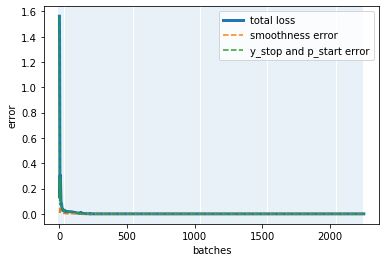

In [66]:
#plot errors after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(p_smoothness_errors, label = 'smoothness error', linestyle='--')
basic = plt.plot(basic_errors, label = 'y_stop and p_start error', linestyle='--')
plt.legend()
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()